With elephant helping and with limit of 26 mins

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as ntx

In [2]:
file_input="input_test.txt"
#file_input="input.txt"

In [3]:
with open(file_input,'r') as f:
    lines = f.readlines()

Create two containers
1. valves and  flow rates list (to be sorted)
2. valve destinations dictionary

In [4]:
valves_to_rate = []
valves_to_rate_dict={}
valves_to_dest = {}

for line0 in lines:
    valve_name = line0.lstrip('Valve ')[:2]
    valve_flowr = int(line0.split(';')[0].split('=')[1])
    valves_to_rate.append( [ valve_name, valve_flowr])
    valves_to_rate_dict[valve_name]=valve_flowr

    dest_valves=None
    s="tunnels lead to valves"
    i0 = line0.find(s)
    if i0<0:
        s= "tunnel leads to valve"
        i0=line0.find(s)
    
    if i0>=0:
        dest_valves_str=line0[i0+len(s):]
        dest_valves= [s.strip(' ').strip('\n') for s in dest_valves_str.split(',')]

        valves_to_dest[valve_name] = dest_valves


In [5]:
valves_to_rate

[['AA', 0],
 ['BB', 13],
 ['CC', 2],
 ['DD', 20],
 ['EE', 3],
 ['FF', 0],
 ['GG', 0],
 ['HH', 22],
 ['II', 0],
 ['JJ', 21]]

In [6]:
valves_to_rate_dict

{'AA': 0,
 'BB': 13,
 'CC': 2,
 'DD': 20,
 'EE': 3,
 'FF': 0,
 'GG': 0,
 'HH': 22,
 'II': 0,
 'JJ': 21}

In [7]:
valves_to_dest

{'AA': ['DD', 'II', 'BB'],
 'BB': ['CC', 'AA'],
 'CC': ['DD', 'BB'],
 'DD': ['CC', 'AA', 'EE'],
 'EE': ['FF', 'DD'],
 'FF': ['EE', 'GG'],
 'GG': ['FF', 'HH'],
 'HH': ['GG'],
 'II': ['AA', 'JJ'],
 'JJ': ['II']}

Create a graph from valves_to_dest

In [8]:
G = ntx.Graph()
for k0 in valves_to_dest.keys():
    G.add_node(k0)
for key, value in valves_to_dest.items():
    for v0 in value:
        G.add_edge(key,v0)

View graph

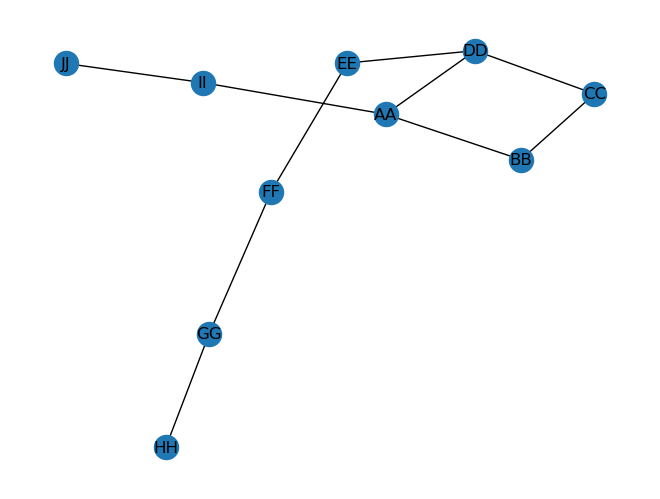

In [9]:
ntx.draw(G, with_labels=True)

These lists will be useful later

In [10]:
closed_valves_sorted = valves_to_rate.copy()
#Sorted by rel value
closed_valves_sorted = sorted(closed_valves_sorted,key=lambda x: x[1], reverse=True)
closed_valves_sorted

[['HH', 22],
 ['JJ', 21],
 ['DD', 20],
 ['BB', 13],
 ['EE', 3],
 ['CC', 2],
 ['AA', 0],
 ['FF', 0],
 ['GG', 0],
 ['II', 0]]

In [11]:
#Create a sorted list where valves with zero have been removed
closed_valves_to_open = closed_valves_sorted.copy()
for it in closed_valves_sorted:
    if it[1]==0:
        closed_valves_to_open.remove(it)

#Create a list of valves not to try open
closed_valves_keep_closed = []
for v0 in closed_valves_sorted:
    if v0[1]==0:
        closed_valves_keep_closed.append(v0)

print(closed_valves_to_open)
print()
print(closed_valves_keep_closed)

[['HH', 22], ['JJ', 21], ['DD', 20], ['BB', 13], ['EE', 3], ['CC', 2]]

[['AA', 0], ['FF', 0], ['GG', 0], ['II', 0]]


# search algorithm (elephant)

Do algorithm minute by minute

Go from non-opened valve to non-opened valve, me and elephant

Keep track of remaining minutes, rather than elapsed minutes

Once valve is open, its contribution to the final total pressure is remaining_minutes*valve_value

Contributions add-up

Write function:
From a valve location, search for possible destinations.

Calculate score for each and collect the maximum only
To calcualate score in each destination, call this function recursively and passing closed valves info.

Return maximum

In [12]:
closed_valves_to_open

[['HH', 22], ['JJ', 21], ['DD', 20], ['BB', 13], ['EE', 3], ['CC', 2]]

In [13]:
closed_valves_to_open1 =[]
for it,value in closed_valves_to_open:
    closed_valves_to_open1.append(it)
closed_valves_to_open1

#Use this format of closed valves

['HH', 'JJ', 'DD', 'BB', 'EE', 'CC']

In [14]:
def getMaxPressContribFromLoc(me_cur_loc, me_path, eleph_cur_loc, eleph_path, closed_valves0, minutes_remain0):

    print(f'Mins:{minutes_remain0}, me_cur_loc: {me_cur_loc} , me_path:{me_path} , eleph_cur_loc:{eleph_cur_loc} , eleph_path:{eleph_path}. closed_valves0:{closed_valves0}')
    minutes_remain1 = minutes_remain0-1

    #print(f"cur_loc:{cur_loc0}, minutes_remain:{minutes_remain0}, closed_valves:{closed_valves0}")
    MaxPressContrib=0

    if minutes_remain1>0:
        #press_contib=0

        me_cur_loc1=me_cur_loc
        eleph_cur_loc1 = eleph_cur_loc

        closed_valves1= closed_valves0.copy()

        me_path1=[]
        eleph_path1=[]

        me_set_new_dests = False
        if len(me_path)==0:
            #No destination yet
            #Is this a valve to open?
            if me_cur_loc in closed_valves1:
                #OPEN this valve, stay at this location, don't setup destinations yet
                print(f"Me OPENS valve {me_cur_loc}")
                closed_valves1.remove(me_cur_loc)
                MaxPressContrib+=valves_to_rate_dict[me_cur_loc]*minutes_remain1
            else:
                #Set new destinations
                me_set_new_dests = True
        else:
            #Use value in me_path for next destination
            me_path1= me_path.copy()
            me_cur_loc1 = me_path1[0]
            me_path1.remove(me_cur_loc1)

        eleph_set_new_dests = False
        if len(eleph_path)==0:
            #No destination yet
            #Is this a valve to open?
            if eleph_cur_loc in closed_valves1:
                #OPEN this valve, stay at this location, don't setup destinations yet
                print(f"Elephant OPENS valve {eleph_cur_loc}")
                closed_valves1.remove(eleph_cur_loc)
                MaxPressContrib+=valves_to_rate_dict[eleph_cur_loc]*minutes_remain1
            else:
                #Completed last move
                #Set new destinations
                eleph_set_new_dests = True
        else:
            #Use value in me_path for next destination
            eleph_path1= eleph_path.copy()
            eleph_cur_loc1 = eleph_path1[0]
            eleph_path1.remove(eleph_cur_loc1)

        if me_set_new_dests and eleph_set_new_dests:
            #Need to choose destinations for both me and elephant
            #Avoid repeting destinations.
            #Choose destinations in a for loop
            #Construct tuples of destinations to explore
            new_destinations = []
            for i0, d0 in enumerate(closed_valves1):
                for i1 in range(i0+1, len(closed_valves1)):
                    d1 = closed_valves1[i1]
                    new_destinations.append((d0,d1))
            print(f"new_destinations list:{new_destinations}")

            #Try all these destinations and collect maximum score
            max_score=0
            for d1,d2 in new_destinations:
                #Get paths to new destinations
                print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc1} , eleph_cur_loc:{eleph_cur_loc1} ")
                #print(f"new destinations: me {d1} , eleph {d2}")
                me_path1 = ntx.shortest_path(G,me_cur_loc1, d1)[1:]
                eleph_path1 = ntx.shortest_path(G,eleph_cur_loc1,d2)[1:]
                print(f"new destinations: me {d1} path {me_path1}, eleph {d2} path {eleph_path1}")
                
                #Make the new move
                me_cur_loc1 = me_path1[0]
                me_path1.remove(me_cur_loc1)
                eleph_cur_loc1 = eleph_path1[0]
                eleph_path1.remove(eleph_cur_loc1)
                score = getMaxPressContribFromLoc(me_cur_loc1, me_path1, eleph_cur_loc1, eleph_path1, closed_valves1, minutes_remain1) 
                max_score= max( max_score,score )
            MaxPressContrib+=max_score #probably don't need the +=, just =

        else:
            if me_set_new_dests and not eleph_set_new_dests:
                #Only needs to set new destination for me, elephant continues
                max_score=0
                for d1 in closed_valves1:
                    #Check the elephant is not heading that way already
                    
                    bcontinue=True
                    if len(eleph_path1)>0:
                        if eleph_path[-1]==d1:
                            bcontinue=False

                    if bcontinue:
                        print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc1} , eleph_cur_loc:{eleph_cur_loc1} ")
                        me_path1 = ntx.shortest_path(G,me_cur_loc1, d1)[1:]
                        print(f"Me new destination {d1}, following path {me_path1}")
                        #Make the new move
                        me_cur_loc1 = me_path1[0]
                        me_path1.remove(me_cur_loc1)
                        score = getMaxPressContribFromLoc(me_cur_loc1, me_path1, eleph_cur_loc1, eleph_path1, closed_valves1, minutes_remain1)
                        max_score= max( max_score, score )
                MaxPressContrib+=max_score

            elif not me_set_new_dests and eleph_set_new_dests:
                #Only needs to set new destination for elephant, me continues
                max_score=0
                #closed_valves2=closed_valves1.copy()
                ilen = len(closed_valves1)
                #print(f"closed_valves1: {closed_valves1}, ilen: {ilen}")
                print(f"ilen: {ilen}")
                #Something is wrong with this for loop, even though the list is empty it still runs the for loop and picks one element
                for i,d1 in enumerate(closed_valves1):
                    #Check me is not heading that way already
                    bcontinue=True
                    if len(me_path1)>0:
                        if me_path1[-1]==d1:
                            bcontinue=False
                    if bcontinue:
                        print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc1} , eleph_cur_loc:{eleph_cur_loc1} ")
                        print(f"closed_valves1:{closed_valves1}, i:{i}, d1:{d1}, ilen:{ilen}")
                        eleph_path1 = ntx.shortest_path(G,eleph_cur_loc1, d1)[1:]
                        print(f"Elephant new destination {d1}, following path {eleph_path1}")
                        #Make the new move
                        eleph_cur_loc1 = eleph_path1[0]
                        eleph_path1.remove(eleph_cur_loc1)
                        score=getMaxPressContribFromLoc(me_cur_loc1, me_path1, eleph_cur_loc1, eleph_path1, closed_valves1, minutes_remain1)
                        max_score= max( max_score, score )
                MaxPressContrib+=max_score

            else:
                #Not setting new destinations, just move to next location and collect score
                MaxPressContrib = getMaxPressContribFromLoc(me_cur_loc1, me_path1, eleph_cur_loc1, eleph_path1, closed_valves1, minutes_remain1)

    print (f"Returning score: {MaxPressContrib}")
    return MaxPressContrib

In [15]:
#getMaxPressContribFromLoc('AA', [], 'AA',[],closed_valves_to_open1, 26)

In [39]:
def getMaxPressContribFromLoc1(me_cur_loc, me_path, me_target , eleph_cur_loc, eleph_path, eleph_target, closed_valves0, minutes_remain0):

    print(f'Mins:{minutes_remain0}, me_cur_loc: {me_cur_loc} , me_path:{me_path} , me_target:{me_target} , eleph_cur_loc:{eleph_cur_loc} , eleph_path:{eleph_path}, eleph_target:{eleph_target}, closed_valves0:{closed_valves0}')
    minutes_remain1 = minutes_remain0-1

    #print(f"cur_loc:{cur_loc0}, minutes_remain:{minutes_remain0}, closed_valves:{closed_valves0}")
    MaxPressContrib=0

    if minutes_remain1>0:

        me_cur_loc1=me_cur_loc
        eleph_cur_loc1 = eleph_cur_loc

        closed_valves1= closed_valves0.copy()

        me_path1=[]
        eleph_path1=[]

        me_set_new_dests = False
        
        if me_target== me_cur_loc:
            if me_cur_loc in closed_valves1: #double check
                #OPEN this valve, stay at this location, don't setup destinations yet
                print(f"Mins:{minutes_remain1},Me OPENS valve {me_cur_loc}")
                closed_valves1.remove(me_cur_loc)
                MaxPressContrib+=valves_to_rate_dict[me_cur_loc1]*minutes_remain1
                me_target=None
            else:
                me_target=None
        elif me_target is None:
            #Set new destinations
            me_set_new_dests = True
        else:
            #Use value in me_path for next destination
            me_path1= me_path.copy()
            me_cur_loc1 = me_path1[0]
            me_path1.remove(me_cur_loc1)

        eleph_set_new_dests=False
        if eleph_target== eleph_cur_loc:
            if eleph_cur_loc in closed_valves1: #double check
                #OPEN this valve, stay at this location, don't setup destinations yet
                print(f"Mins:{minutes_remain1}, Eleph OPENS valve {eleph_cur_loc}")
                closed_valves1.remove(eleph_cur_loc)
                MaxPressContrib+=valves_to_rate_dict[eleph_cur_loc]*minutes_remain1
                eleph_target=None
            else:
                eleph_target=None
        elif eleph_target is None:
            #Set new destinations
            eleph_set_new_dests = True
        else:
            #Use value in me_path for next destination
            eleph_path1= eleph_path.copy()
            eleph_cur_loc1 = eleph_path1[0]
            eleph_path1.remove(eleph_cur_loc1)



        if me_set_new_dests and eleph_set_new_dests:
            #Need to choose destinations for both me and elephant
            #Avoid repeting destinations.
            #Choose destinations in a for loop
            #Construct tuples of destinations to explore
            new_destinations = []
            for i0, d0 in enumerate(closed_valves1):
                for i1 in range(i0+1, len(closed_valves1)):
                    d1 = closed_valves1[i1]
                    new_destinations.append((d0,d1))
            print(f"Mins:{minutes_remain1}, new_destinations list:{new_destinations}")

            #Try all these destinations and collect maximum score
            max_score=0

            for d1,d2 in new_destinations:
                #Get paths to new destinations
                print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc} , eleph_cur_loc:{eleph_cur_loc} ")
                #print(f"new destinations: me {d1} , eleph {d2}")
                me_path1 = ntx.shortest_path(G,me_cur_loc, d1)[1:]
                eleph_path1 = ntx.shortest_path(G,eleph_cur_loc,d2)[1:]
                print(f"destinations: me {d1} path {me_path1}, eleph {d2} path {eleph_path1}")

                me_target1 = d1
                eleph_target1 = d2

                #Make the new move
                me_cur_loc1 = me_path1[0]
                me_path1.remove(me_cur_loc1)
                eleph_cur_loc1 = eleph_path1[0]
                eleph_path1.remove(eleph_cur_loc1)
                score = getMaxPressContribFromLoc1(me_cur_loc1, me_path1, me_target1, eleph_cur_loc1, eleph_path1, eleph_target1, closed_valves1, minutes_remain1) 

                if score>max_score:
                    max_score = score

            MaxPressContrib+=max_score #probably don't need the +=, just =


        else:
            if me_set_new_dests and not eleph_set_new_dests:
                #Only needs to set new destination for me, elephant continues
                max_score=0

                for d1 in closed_valves1:
                    #Check the elephant is not heading that way already
                    if not d1==eleph_target:
                        me_target1 = d1
                        print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc} , eleph_cur_loc:{eleph_cur_loc1} ")
                        me_path1 = ntx.shortest_path(G,me_cur_loc, d1)[1:]
                        print(f"Me new destination {d1}, following path {me_path1}")
                        #Make the new move
                        me_cur_loc1 = me_path1[0]
                        me_path1.remove(me_cur_loc1)
                        score = getMaxPressContribFromLoc1(me_cur_loc1, me_path1, me_target1, eleph_cur_loc1, eleph_path1, eleph_target, closed_valves1, minutes_remain1)

                        if score>max_score:
                            max_score = score

                MaxPressContrib+=max_score

            elif not me_set_new_dests and eleph_set_new_dests:
                #Only needs to set new destination for elephant, me continues
                max_score=0

                #closed_valves2=closed_valves1.copy()
                #ilen = len(closed_valves1)
                #print(f"closed_valves1: {closed_valves1}, ilen: {ilen}")
                #print(f"ilen: {ilen}")
                #Something is wrong with this for loop, even though the list is empty it still runs the for loop and picks one element
                for i,d1 in enumerate(closed_valves1):
                    #Check me is not heading that way already
                    if not d1==me_target:
                        eleph_target1 = d1
                        print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc} , eleph_cur_loc:{eleph_cur_loc} ")
                        #print(f"closed_valves1:{closed_valves1}, i:{i}, d1:{d1}, ilen:{ilen}")
                        eleph_path1 = ntx.shortest_path(G,eleph_cur_loc, d1)[1:]
                        print(f"Elephant new destination {d1}, following path {eleph_path1}")
                        #Make the new move
                        eleph_cur_loc1 = eleph_path1[0]
                        eleph_path1.remove(eleph_cur_loc1)
                        score =getMaxPressContribFromLoc1(me_cur_loc1, me_path1, me_target, eleph_cur_loc1, eleph_path1, eleph_target1, closed_valves1, minutes_remain1)
                        if score>max_score:
                            max_score = score

                MaxPressContrib+=max_score

            else:
                #Not setting new destinations, just move to next location and collect score
                #me_target1 = None
                #eleph_target1=None
                #me_cur_loc1 = me_cur_loc
                #eleph_cur_loc1= eleph_cur_loc
                score = getMaxPressContribFromLoc1(me_cur_loc1, me_path1, me_target, eleph_cur_loc1, eleph_path1, eleph_target, closed_valves1, minutes_remain1)
                MaxPressContrib += score

    print (f"Mins:{minutes_remain1}, Returning score: {MaxPressContrib}")

    return MaxPressContrib

In [41]:
getMaxPressContribFromLoc1('AA', [], None, 'AA',[],None, closed_valves_to_open1, 26)

Mins:26, me_cur_loc: AA , me_path:[] , me_target:None , eleph_cur_loc:AA , eleph_path:[], eleph_target:None, closed_valves0:['HH', 'JJ', 'DD', 'BB', 'EE', 'CC']
Mins:25, new_destinations list:[('HH', 'JJ'), ('HH', 'DD'), ('HH', 'BB'), ('HH', 'EE'), ('HH', 'CC'), ('JJ', 'DD'), ('JJ', 'BB'), ('JJ', 'EE'), ('JJ', 'CC'), ('DD', 'BB'), ('DD', 'EE'), ('DD', 'CC'), ('BB', 'EE'), ('BB', 'CC'), ('EE', 'CC')]
Mins:25, me_cur_loc: AA , eleph_cur_loc:AA 
destinations: me HH path ['DD', 'EE', 'FF', 'GG', 'HH'], eleph JJ path ['II', 'JJ']
Mins:25, me_cur_loc: DD , me_path:['EE', 'FF', 'GG', 'HH'] , me_target:HH , eleph_cur_loc:II , eleph_path:['JJ'], eleph_target:JJ, closed_valves0:['HH', 'JJ', 'DD', 'BB', 'EE', 'CC']
Mins:24, me_cur_loc: EE , me_path:['FF', 'GG', 'HH'] , me_target:HH , eleph_cur_loc:JJ , eleph_path:[], eleph_target:JJ, closed_valves0:['HH', 'JJ', 'DD', 'BB', 'EE', 'CC']
Mins:23, Eleph OPENS valve JJ
Mins:23, me_cur_loc: FF , me_path:['GG', 'HH'] , me_target:HH , eleph_cur_loc:JJ , 

1706

In [43]:
def getMaxPressContribFromLoc_with_route_track(me_cur_loc, me_path, me_target , eleph_cur_loc, eleph_path, eleph_target, closed_valves0, minutes_remain0):

    print(f'Mins:{minutes_remain0}, me_cur_loc: {me_cur_loc} , me_path:{me_path} , me_target:{me_target} , eleph_cur_loc:{eleph_cur_loc} , eleph_path:{eleph_path}, eleph_target:{eleph_target}, closed_valves0:{closed_valves0}')
    minutes_remain1 = minutes_remain0-1

    #print(f"cur_loc:{cur_loc0}, minutes_remain:{minutes_remain0}, closed_valves:{closed_valves0}")
    MaxPressContrib=0

    me_route1= [me_cur_loc]
    eleph_route1= [eleph_cur_loc]

    if minutes_remain1>0:

        me_cur_loc1=me_cur_loc
        eleph_cur_loc1 = eleph_cur_loc

        closed_valves1= closed_valves0.copy()

        me_path1=[]
        eleph_path1=[]

        me_set_new_dests = False
        
        if me_target== me_cur_loc:
            if me_cur_loc in closed_valves1: #double check
                #OPEN this valve, stay at this location, don't setup destinations yet
                print(f"Mins:{minutes_remain1},Me OPENS valve {me_cur_loc}")
                closed_valves1.remove(me_cur_loc)
                MaxPressContrib+=valves_to_rate_dict[me_cur_loc1]*minutes_remain1
                me_target=None
            else:
                me_target=None
        elif me_target is None:
            #Set new destinations
            me_set_new_dests = True
        else:
            #Use value in me_path for next destination
            me_path1= me_path.copy()
            me_cur_loc1 = me_path1[0]
            me_path1.remove(me_cur_loc1)

        eleph_set_new_dests=False
        if eleph_target== eleph_cur_loc:
            if eleph_cur_loc in closed_valves1: #double check
                #OPEN this valve, stay at this location, don't setup destinations yet
                print(f"Mins:{minutes_remain1}, Eleph OPENS valve {eleph_cur_loc}")
                closed_valves1.remove(eleph_cur_loc)
                MaxPressContrib+=valves_to_rate_dict[eleph_cur_loc]*minutes_remain1
                eleph_target=None
            else:
                eleph_target=None
        elif eleph_target is None:
            #Set new destinations
            eleph_set_new_dests = True
        else:
            #Use value in me_path for next destination
            eleph_path1= eleph_path.copy()
            eleph_cur_loc1 = eleph_path1[0]
            eleph_path1.remove(eleph_cur_loc1)



        if me_set_new_dests and eleph_set_new_dests:
            #Need to choose destinations for both me and elephant
            #Avoid repeting destinations.
            #Choose destinations in a for loop
            #Construct tuples of destinations to explore
            new_destinations = []
            for i0, d0 in enumerate(closed_valves1):
                for i1 in range(i0+1, len(closed_valves1)):
                    d1 = closed_valves1[i1]
                    new_destinations.append((d0,d1))
            print(f"Mins:{minutes_remain1}, new_destinations list:{new_destinations}")

            #Try all these destinations and collect maximum score
            max_score=0
            me_route_max=None
            eleph_route_max=None
            for d1,d2 in new_destinations:
                #Get paths to new destinations
                print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc} , eleph_cur_loc:{eleph_cur_loc} ")
                #print(f"new destinations: me {d1} , eleph {d2}")
                me_path1 = ntx.shortest_path(G,me_cur_loc, d1)[1:]
                eleph_path1 = ntx.shortest_path(G,eleph_cur_loc,d2)[1:]
                print(f"destinations: me {d1} path {me_path1}, eleph {d2} path {eleph_path1}")

                me_target1 = d1
                eleph_target1 = d2

                #Make the new move
                me_cur_loc1 = me_path1[0]
                me_path1.remove(me_cur_loc1)
                eleph_cur_loc1 = eleph_path1[0]
                eleph_path1.remove(eleph_cur_loc1)
                score, me_route, eleph_route = getMaxPressContribFromLoc_with_route_track(me_cur_loc1, me_path1, me_target1, eleph_cur_loc1, eleph_path1, eleph_target1, closed_valves1, minutes_remain1) 

                if score>max_score:
                    max_score = score
                    me_route_max = me_route
                    eleph_route_max = eleph_route

            MaxPressContrib+=max_score #probably don't need the +=, just =
            me_route1.extend(me_route_max)
            eleph_route1.extend(eleph_route_max)

        else:
            if me_set_new_dests and not eleph_set_new_dests:
                #Only needs to set new destination for me, elephant continues
                max_score=0
                me_route_max=None
                eleph_route_max=None
                for d1 in closed_valves1:
                    #Check the elephant is not heading that way already
                    if not d1==eleph_target:
                        me_target1 = d1
                        print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc} , eleph_cur_loc:{eleph_cur_loc1} ")
                        me_path1 = ntx.shortest_path(G,me_cur_loc, d1)[1:]
                        print(f"Me new destination {d1}, following path {me_path1}")
                        #Make the new move
                        me_cur_loc1 = me_path1[0]
                        me_path1.remove(me_cur_loc1)
                        score, me_route, eleph_route = getMaxPressContribFromLoc_with_route_track(me_cur_loc1, me_path1, me_target1, eleph_cur_loc1, eleph_path1, eleph_target, closed_valves1, minutes_remain1)

                        if score>max_score:
                            max_score = score
                            me_route_max = me_route
                            eleph_route_max = eleph_route
                MaxPressContrib+=max_score
                me_route1.extend(me_route_max)
                eleph_route1.extend(eleph_route_max)

            elif not me_set_new_dests and eleph_set_new_dests:
                #Only needs to set new destination for elephant, me continues
                max_score=0
                me_route_max=None
                eleph_route_max=None
                #closed_valves2=closed_valves1.copy()
                #ilen = len(closed_valves1)
                #print(f"closed_valves1: {closed_valves1}, ilen: {ilen}")
                #print(f"ilen: {ilen}")
                #Something is wrong with this for loop, even though the list is empty it still runs the for loop and picks one element
                for i,d1 in enumerate(closed_valves1):
                    #Check me is not heading that way already
                    if not d1==me_target:
                        eleph_target1 = d1
                        print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc} , eleph_cur_loc:{eleph_cur_loc} ")
                        #print(f"closed_valves1:{closed_valves1}, i:{i}, d1:{d1}, ilen:{ilen}")
                        eleph_path1 = ntx.shortest_path(G,eleph_cur_loc, d1)[1:]
                        print(f"Elephant new destination {d1}, following path {eleph_path1}")
                        #Make the new move
                        eleph_cur_loc1 = eleph_path1[0]
                        eleph_path1.remove(eleph_cur_loc1)
                        score, me_route, eleph_route =getMaxPressContribFromLoc_with_route_track(me_cur_loc1, me_path1, me_target, eleph_cur_loc1, eleph_path1, eleph_target1, closed_valves1, minutes_remain1)
                        
                        if score>max_score:
                            max_score = score
                            me_route_max = me_route
                            eleph_route_max = eleph_route
                MaxPressContrib+=max_score
                me_route1.extend(me_route_max)
                eleph_route1.extend(eleph_route_max)

            else:
                #Not setting new destinations, just move to next location and collect score
                #me_target1 = None
                #eleph_target1=None
                #me_cur_loc1 = me_cur_loc
                #eleph_cur_loc1= eleph_cur_loc
                score, me_route, eleph_route = getMaxPressContribFromLoc_with_route_track(me_cur_loc1, me_path1, me_target, eleph_cur_loc1, eleph_path1, eleph_target, closed_valves1, minutes_remain1)
                MaxPressContrib += score
                me_route1.extend(me_route)
                eleph_route1.extend(eleph_route)
    print (f"Mins:{minutes_remain1}, Returning score: {MaxPressContrib}")

    return MaxPressContrib, me_route1, eleph_route1

In [44]:
getMaxPressContribFromLoc_with_route_track('AA', [], None, 'AA',[],None, closed_valves_to_open1, 26)

Mins:26, me_cur_loc: AA , me_path:[] , me_target:None , eleph_cur_loc:AA , eleph_path:[], eleph_target:None, closed_valves0:['HH', 'JJ', 'DD', 'BB', 'EE', 'CC']
Mins:25, new_destinations list:[('HH', 'JJ'), ('HH', 'DD'), ('HH', 'BB'), ('HH', 'EE'), ('HH', 'CC'), ('JJ', 'DD'), ('JJ', 'BB'), ('JJ', 'EE'), ('JJ', 'CC'), ('DD', 'BB'), ('DD', 'EE'), ('DD', 'CC'), ('BB', 'EE'), ('BB', 'CC'), ('EE', 'CC')]
Mins:25, me_cur_loc: AA , eleph_cur_loc:AA 
destinations: me HH path ['DD', 'EE', 'FF', 'GG', 'HH'], eleph JJ path ['II', 'JJ']
Mins:25, me_cur_loc: DD , me_path:['EE', 'FF', 'GG', 'HH'] , me_target:HH , eleph_cur_loc:II , eleph_path:['JJ'], eleph_target:JJ, closed_valves0:['HH', 'JJ', 'DD', 'BB', 'EE', 'CC']
Mins:24, me_cur_loc: EE , me_path:['FF', 'GG', 'HH'] , me_target:HH , eleph_cur_loc:JJ , eleph_path:[], eleph_target:JJ, closed_valves0:['HH', 'JJ', 'DD', 'BB', 'EE', 'CC']
Mins:23, Eleph OPENS valve JJ
Mins:23, me_cur_loc: FF , me_path:['GG', 'HH'] , me_target:HH , eleph_cur_loc:JJ , 

TypeError: 'NoneType' object is not iterable

In [ ]:
def getMaxPressContribFromLoc1_nodebug(me_cur_loc, me_path, me_target , eleph_cur_loc, eleph_path, eleph_target, closed_valves0, minutes_remain0):

    #print(f'Mins:{minutes_remain0}, me_cur_loc: {me_cur_loc} , me_path:{me_path} , me_target:{me_target} , eleph_cur_loc:{eleph_cur_loc} , eleph_path:{eleph_path}, eleph_target:{eleph_target}, closed_valves0:{closed_valves0}')
    minutes_remain1 = minutes_remain0-1

    #print(f"cur_loc:{cur_loc0}, minutes_remain:{minutes_remain0}, closed_valves:{closed_valves0}")
    MaxPressContrib=0

    if minutes_remain1>0:

        me_cur_loc1=me_cur_loc
        eleph_cur_loc1 = eleph_cur_loc

        closed_valves1= closed_valves0.copy()

        me_path1=[]
        eleph_path1=[]

        me_set_new_dests = False
        
        if me_target== me_cur_loc:
            if me_cur_loc in closed_valves1: #double check
                #OPEN this valve, stay at this location, don't setup destinations yet
                #print(f"Mins:{minutes_remain1},Me OPENS valve {me_cur_loc}")
                closed_valves1.remove(me_cur_loc)
                MaxPressContrib+=valves_to_rate_dict[me_cur_loc1]*minutes_remain1
                me_target=None
            else:
                me_target=None
        elif me_target is None:
            #Set new destinations
            me_set_new_dests = True
        else:
            #Use value in me_path for next destination
            me_path1= me_path.copy()
            me_cur_loc1 = me_path1[0]
            me_path1.remove(me_cur_loc1)

        eleph_set_new_dests=False
        if eleph_target== eleph_cur_loc:
            if eleph_cur_loc in closed_valves1: #double check
                #OPEN this valve, stay at this location, don't setup destinations yet
                #print(f"Mins:{minutes_remain1}, Eleph OPENS valve {eleph_cur_loc}")
                closed_valves1.remove(eleph_cur_loc)
                MaxPressContrib+=valves_to_rate_dict[eleph_cur_loc]*minutes_remain1
                eleph_target=None
            else:
                eleph_target=None
        elif eleph_target is None:
            #Set new destinations
            eleph_set_new_dests = True
        else:
            #Use value in me_path for next destination
            eleph_path1= eleph_path.copy()
            eleph_cur_loc1 = eleph_path1[0]
            eleph_path1.remove(eleph_cur_loc1)



        if me_set_new_dests and eleph_set_new_dests:
            #Need to choose destinations for both me and elephant
            #Avoid repeting destinations.
            #Choose destinations in a for loop
            #Construct tuples of destinations to explore
            new_destinations = []
            for i0, d0 in enumerate(closed_valves1):
                for i1 in range(i0+1, len(closed_valves1)):
                    d1 = closed_valves1[i1]
                    new_destinations.append((d0,d1))
            #print(f"Mins:{minutes_remain1}, new_destinations list:{new_destinations}")

            #Try all these destinations and collect maximum score
            max_score=0
            for d1,d2 in new_destinations:
                #Get paths to new destinations
                #print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc} , eleph_cur_loc:{eleph_cur_loc} ")
                #print(f"new destinations: me {d1} , eleph {d2}")
                me_path1 = ntx.shortest_path(G,me_cur_loc, d1)[1:]
                eleph_path1 = ntx.shortest_path(G,eleph_cur_loc,d2)[1:]
                #print(f"destinations: me {d1} path {me_path1}, eleph {d2} path {eleph_path1}")

                me_target1 = d1
                eleph_target1 = d2

                #Make the new move
                me_cur_loc1 = me_path1[0]
                me_path1.remove(me_cur_loc1)
                eleph_cur_loc1 = eleph_path1[0]
                eleph_path1.remove(eleph_cur_loc1)
                score = getMaxPressContribFromLoc1_nodebug(me_cur_loc1, me_path1, me_target1, eleph_cur_loc1, eleph_path1, eleph_target1, closed_valves1, minutes_remain1) 
                max_score= max( max_score,score )
            MaxPressContrib+=max_score #probably don't need the +=, just =

        else:
            if me_set_new_dests and not eleph_set_new_dests:
                #Only needs to set new destination for me, elephant continues
                max_score=0
                for d1 in closed_valves1:
                    #Check the elephant is not heading that way already
                    if not d1==eleph_target:
                        me_target1 = d1
                        #print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc} , eleph_cur_loc:{eleph_cur_loc1} ")
                        me_path1 = ntx.shortest_path(G,me_cur_loc, d1)[1:]
                        #print(f"Me new destination {d1}, following path {me_path1}")
                        #Make the new move
                        me_cur_loc1 = me_path1[0]
                        me_path1.remove(me_cur_loc1)
                        score = getMaxPressContribFromLoc1_nodebug(me_cur_loc1, me_path1, me_target1, eleph_cur_loc1, eleph_path1, eleph_target, closed_valves1, minutes_remain1)
                        max_score= max( max_score, score )
                MaxPressContrib+=max_score

            elif not me_set_new_dests and eleph_set_new_dests:
                #Only needs to set new destination for elephant, me continues
                max_score=0
                #closed_valves2=closed_valves1.copy()
                #ilen = len(closed_valves1)
                #print(f"closed_valves1: {closed_valves1}, ilen: {ilen}")
                #print(f"ilen: {ilen}")
                #Something is wrong with this for loop, even though the list is empty it still runs the for loop and picks one element
                for i,d1 in enumerate(closed_valves1):
                    #Check me is not heading that way already
                    if not d1==me_target:
                        eleph_target1 = d1
                        #print(f"Mins:{minutes_remain1}, me_cur_loc: {me_cur_loc} , eleph_cur_loc:{eleph_cur_loc} ")
                        #print(f"closed_valves1:{closed_valves1}, i:{i}, d1:{d1}, ilen:{ilen}")
                        eleph_path1 = ntx.shortest_path(G,eleph_cur_loc, d1)[1:]
                        #print(f"Elephant new destination {d1}, following path {eleph_path1}")
                        #Make the new move
                        eleph_cur_loc1 = eleph_path1[0]
                        eleph_path1.remove(eleph_cur_loc1)
                        score=getMaxPressContribFromLoc1_nodebug(me_cur_loc1, me_path1, me_target, eleph_cur_loc1, eleph_path1, eleph_target1, closed_valves1, minutes_remain1)
                        max_score= max( max_score, score )
                MaxPressContrib+=max_score

            else:
                #Not setting new destinations, just move to next location and collect score
                #me_target1 = None
                #eleph_target1=None
                #me_cur_loc1 = me_cur_loc
                #eleph_cur_loc1= eleph_cur_loc
                MaxPressContrib += getMaxPressContribFromLoc1_nodebug(me_cur_loc1, me_path1, me_target, eleph_cur_loc1, eleph_path1, eleph_target, closed_valves1, minutes_remain1)

    #print (f"Mins:{minutes_remain1}, Returning score: {MaxPressContrib}")
    return MaxPressContrib

In [ ]:
getMaxPressContribFromLoc1_nodebug('AA', [], None, 'AA',[],None, closed_valves_to_open1, 26)